In [1]:
import sys
import os
sys.path.append("../src/")
import combat
import numpy as np
import scipy.stats as stats
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
import sklearn
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sb
import pickle as pkl
from sklearn.linear_model import LogisticRegression, Lasso, Ridge, ElasticNet
import random as rd
import matplotlib
matplotlib.rcParams['figure.dpi'] = 500
from sklearn.preprocessing import quantile_transform,binarize
from sklearn.model_selection import LeaveOneOut,KFold
from sklearn.metrics import r2_score
from statsmodels.stats.multitest import multipletests
from sklearn.cross_decomposition import PLSRegression as PLS
import warnings
warnings.simplefilter("ignore")
from multiprocessing import Process,Queue,Pool
import time 
import helper
from multiprocessing import set_start_method
#set_start_method("spawn")
from DecoID.DecoID import flatten
from sklearn.cross_decomposition import PLSRegression
from sklearn.svm import SVC
import importlib
import helper#import the module here, so that it can be reloaded.
importlib.reload(helper)
from statsmodels.stats.anova import AnovaRM


In [2]:
#load in metadata and peak areas and associate

#read in peak data
datafilename = "../data/QTof-B1-9_pHILIC_HSS_pos-neg_normalized.csv"
data = pd.read_csv(datafilename)

#get area columns
areaCols = data.columns.values[10:]

#get molecule names
mol_names = data["Compound Name"].values

#extract area data and transpose
areaData = data[areaCols].transpose()

#get batch information
batchInfo = [int(x.split("_")[0][1]) for x in list(areaData.index.values)]

areaData = areaData.to_numpy()
areaData = areaData.astype(np.float)

#get index of blanks
blankSamp = [x for x in range(len(areaCols)) if "Blank" in areaCols[x] and not "equil" in areaCols[x]]
print(len(blankSamp)," blanks")

#get index of qc
qcSamp = [x for x in range(len(areaCols)) if "NIST" in areaCols[x] and not "equil" in areaCols[x] ]
print(len(qcSamp)," qc samples")

#get index of wu350 samples
samp = [x for x in range(len(areaCols)) if "WU350" in areaCols[x] and not "equil" in areaCols[x]]
print(len(samp), "research samples")

#load in metadata
metadatafn = "../data/Experiment-Parameters_b1-9.csv"
metadata = pd.read_csv(metadatafn)

#extact sample names for d0_yes samples
metadata_rel = metadata[metadata["day-COVID"] == "d0_Yes"]
print(len(metadata_rel)," d0 Covid+ Samples")

            
#create sample name, ventilator status linkage
vent_dict = {}
metadata_dict = {}
for index,row in metadata_rel.iterrows():
    val = str(row["ICU"])
    sampName = row["Sample General Name"]
    if "es" in val:
        val = 1
    elif "o" in val:
        val = 0
    vent_dict[sampName] = val
    metadata_dict[sampName] = row

print(np.sum(list(vent_dict.values()))," ICU+ samples")
print(len(vent_dict) - np.sum(list(vent_dict.values())),"ICU- samples")

#link vent status to sample in peak data
vent_status = []
metadata_for_samples = []
patient_ids = []
ages = []
bmis = []
for s in np.array(areaCols)[samp]:
    tmp = s
    if tmp in vent_dict:
        vent_status.append(vent_dict[tmp])
        metadata_for_samples.append(metadata_dict[tmp])
        patient_ids.append(metadata_dict[tmp]["WU-350"])
        ages.append(float(metadata_dict[tmp]["Age at Symptom onset (years)"]))
        try:
            bmis.append(float(metadata_dict[tmp]["BMI"]))
        except:
            bmis.append(-1)
    else:
        vent_status.append(-1)
        metadata_for_samples.append(-1)
        patient_ids.append(-1)
        ages.append(-1)
        bmis.append(-1)

print("found vent info for",len([x for x in vent_status if x != -1]),"covid_ d0 samples")
samplesOfInterest = [x for x in range(len(vent_status)) if vent_status[x] != -1]
ICU_vals = np.array([x for x in vent_status if x != -1])
ages = np.array(ages)[samplesOfInterest]
bmis = np.array(bmis)[samplesOfInterest]
patient_ids = np.array(patient_ids)[samplesOfInterest]
#create sample matrix
samp_int = np.log2(areaData[samp][samplesOfInterest])

patient_ICU = {id:stat for id,stat in zip(patient_ids,ICU_vals)}
patient_ind = {id:i for id,i in zip(patient_ids,range(len(patient_ids)))}

var_imp = pd.read_csv("../data/var_importance.csv",index_col=0)

vars_of_interest = []
for x in var_imp.index.values:
    index = 0
    for y in mol_names:
        if x == y:
            vars_of_interest.append(index)
            break
        index += 1 
        
samp_int = samp_int[:,vars_of_interest]
mol_names = var_imp.index.values

print(samp_int.shape)

0  blanks
0  qc samples
704 research samples
264  d0 Covid+ Samples
123  ICU+ samples
141 ICU- samples
found vent info for 263 covid_ d0 samples
(263, 38)


In [3]:
measurement_data = pd.read_csv("../data/PMN_CRP_d-dimer_CO2_Comorbidities.csv")
to_drop = []
for index,row in measurement_data.iterrows():
    if row["Patient"] not in patient_ids:
        to_drop.append(index)
measurement_data = measurement_data.drop(to_drop)
plot_df = {}
mapper = {"Yes":1,"No":0}
for patient in measurement_data["Patient"]:
    tmp = measurement_data[measurement_data["Patient"] == patient]
    stat = patient_ICU[patient]
    if len(tmp) > 0:
        hyp = tmp.at[tmp.index.values[0],"Hypoxia"]
        dia = tmp.at[tmp.index.values[0],"Diabetes"]
        kid = tmp.at[tmp.index.values[0],"Kidney Disease"]
        wl = tmp.at[tmp.index.values[0],"Weight Loss"]
        can = tmp.at[tmp.index.values[0],"Cancer"]

        plot_df[patient] = {"ICU":stat,"Hypoxia":hyp,"Diabetes":dia,"Kidney Disease":kid,"Weight Loss":wl,"Cancer":can}

df = pd.DataFrame.from_dict(plot_df,orient="index")
df

,ICU,Hypoxia,Diabetes,Kidney Disease,Weight Loss,Cancer
WU350-013,1,0,0,1,0,0
WU350-014,1,1,1,1,0,0
WU350-015,1,1,0,0,0,0
WU350-018,1,0,1,1,0,0
WU350-021,1,1,1,1,0,0
...,...,...,...,...,...,...
WU350-394,1,0,0,0,0,0
WU350-395,0,0,0,0,0,0
WU350-397,1,0,0,0,0,0
WU350-398,1,0,0,0,0,0


In [4]:
#keep only Kidney Disease -

thresh = .5
alpha = 0.01
insig_mols = []
col = "Kidney Disease"

for l in range(2):
    if l == 0:
        patientsOfInterest = df[df[col] < thresh].index.values
    else:
        patientsOfInterest = df[df[col] >= thresh].index.values

    inds = [patient_ind[x] for x in patientsOfInterest]

    for met in range(len(mol_names)):

        plot_df = {}
        val = samp_int[inds,met]
        index = 0
        for x,y in zip(val,ICU_vals[inds]):
            plot_df[index] = {"ICU":y,"ratio":x}
            index += 1
        
        plot_df = pd.DataFrame.from_dict(plot_df,orient="index")

        stat,p = stats.ttest_ind(plot_df[plot_df["ICU"]==1]["ratio"].values,plot_df[plot_df["ICU"]==0]["ratio"].values,equal_var=False)

        if p > alpha:
            insig_mols.append(met)
        
insig_mols = [x for x in insig_mols if len([y for y in insig_mols if y == x]) > 1]


for met in insig_mols:
    index = 0
    plot_df = {}
    for l in range(2):
        if l == 0:
            patientsOfInterest = df[df[col] < thresh].index.values
            label = col + " -"
        else:
            patientsOfInterest = df[df[col] >= thresh].index.values
            label = col + " +"

        inds = [patient_ind[x] for x in patientsOfInterest]

        val = samp_int[inds,met]
        for x,y in zip(val,ICU_vals[inds]):
            plot_df[index] = {"ICU":y,"normalized intensity":x,"partition":label}
            index += 1

    plot_df = pd.DataFrame.from_dict(plot_df,orient="index")
      
    plt.figure()    
    sb.boxplot(data=plot_df,x="partition",y="normalized intensity",hue="ICU")
    p = sb.swarmplot(data=plot_df,x="partition",y="normalized intensity",hue="ICU",dodge=True)
    plt.title(mol_names[met])
        




4


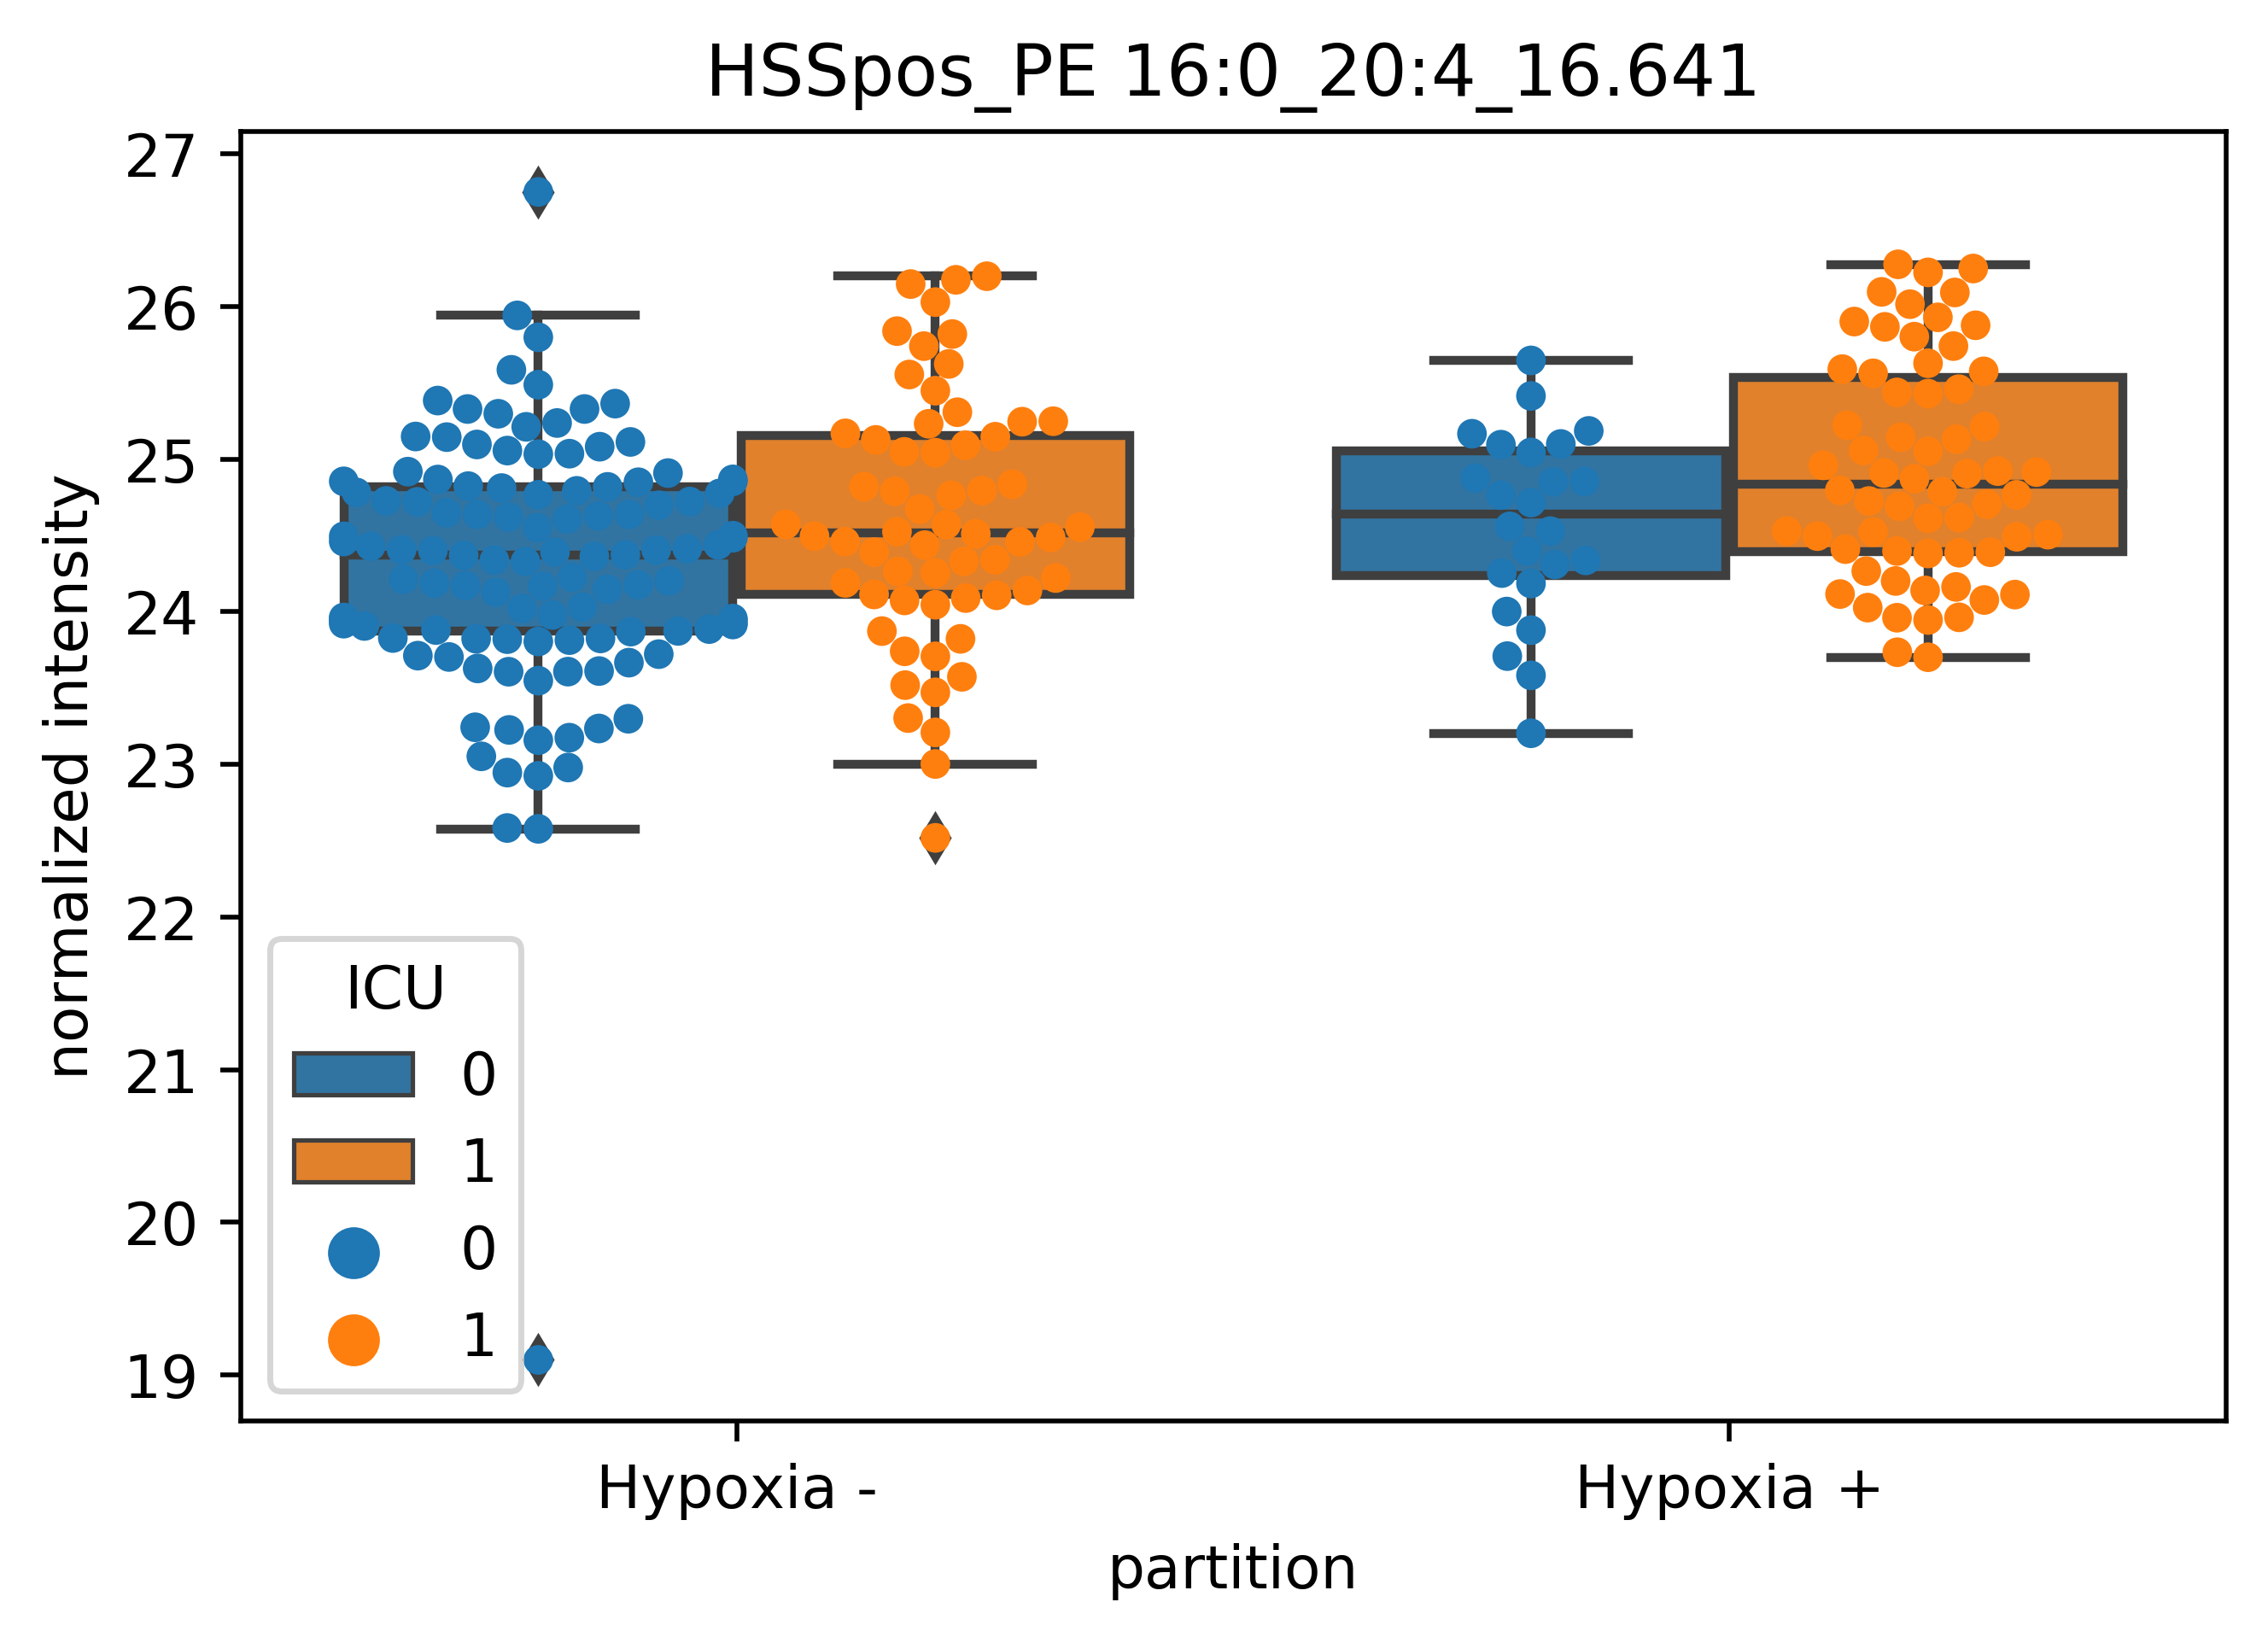

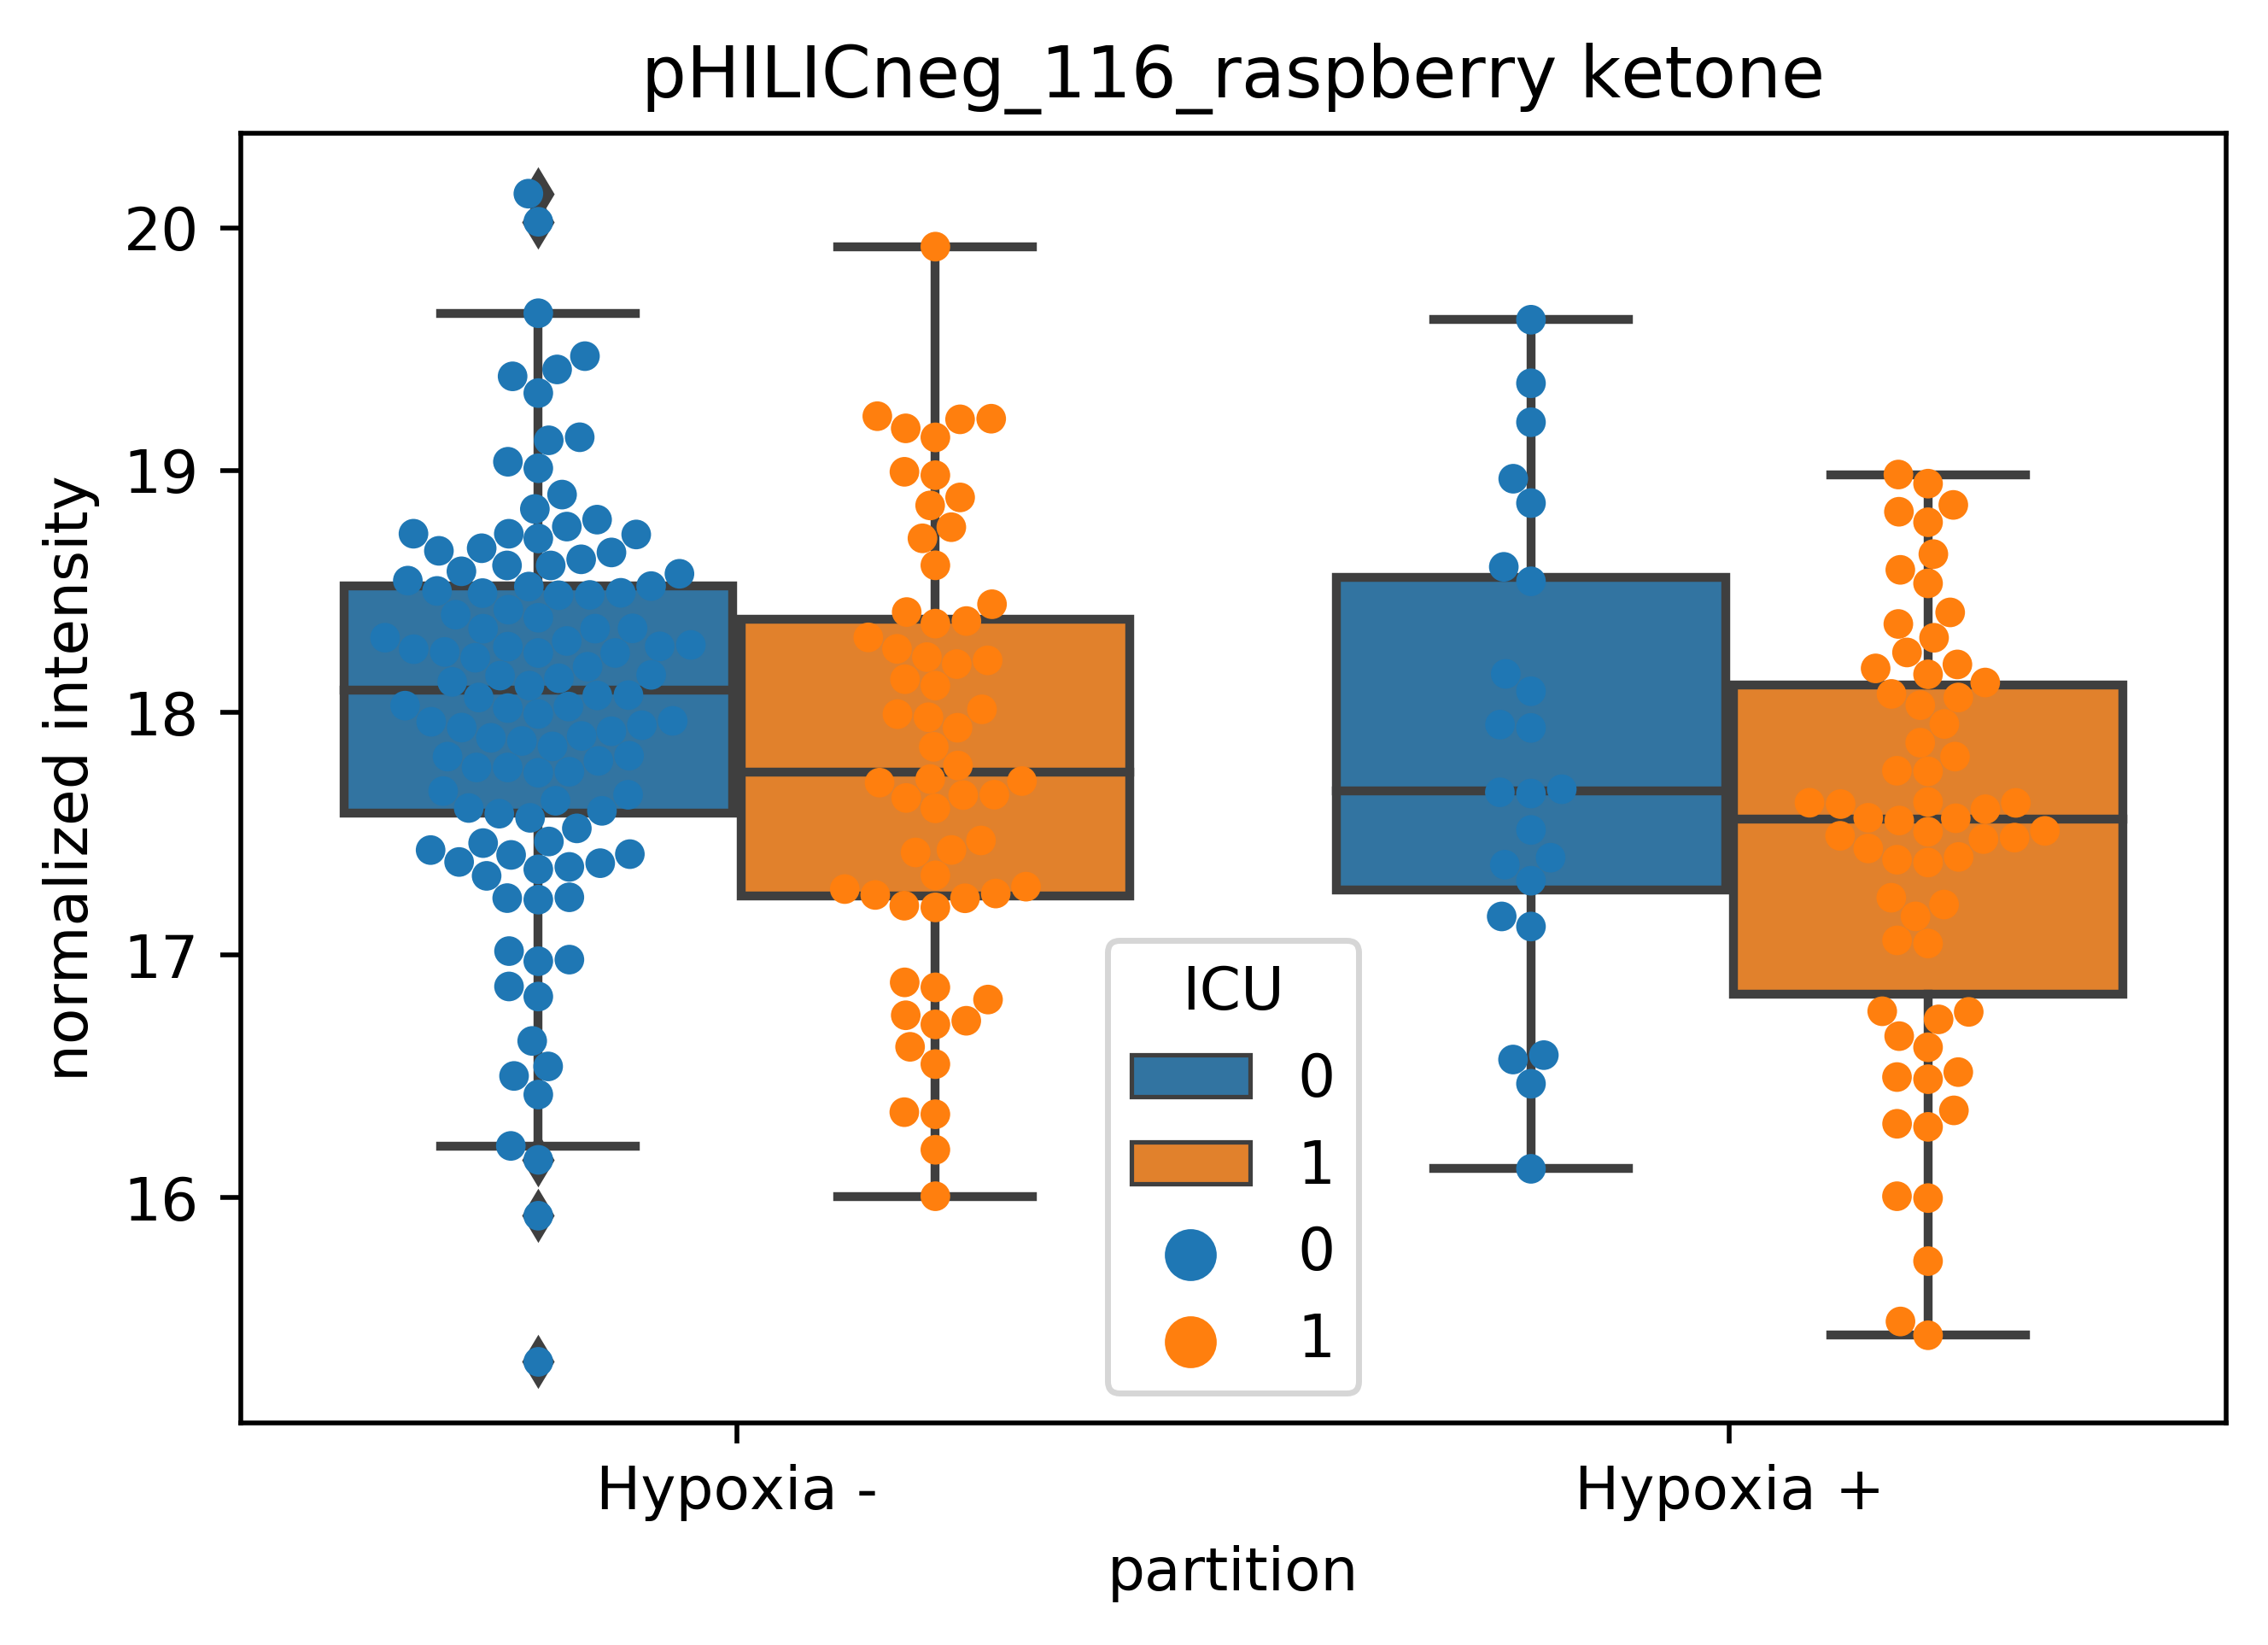

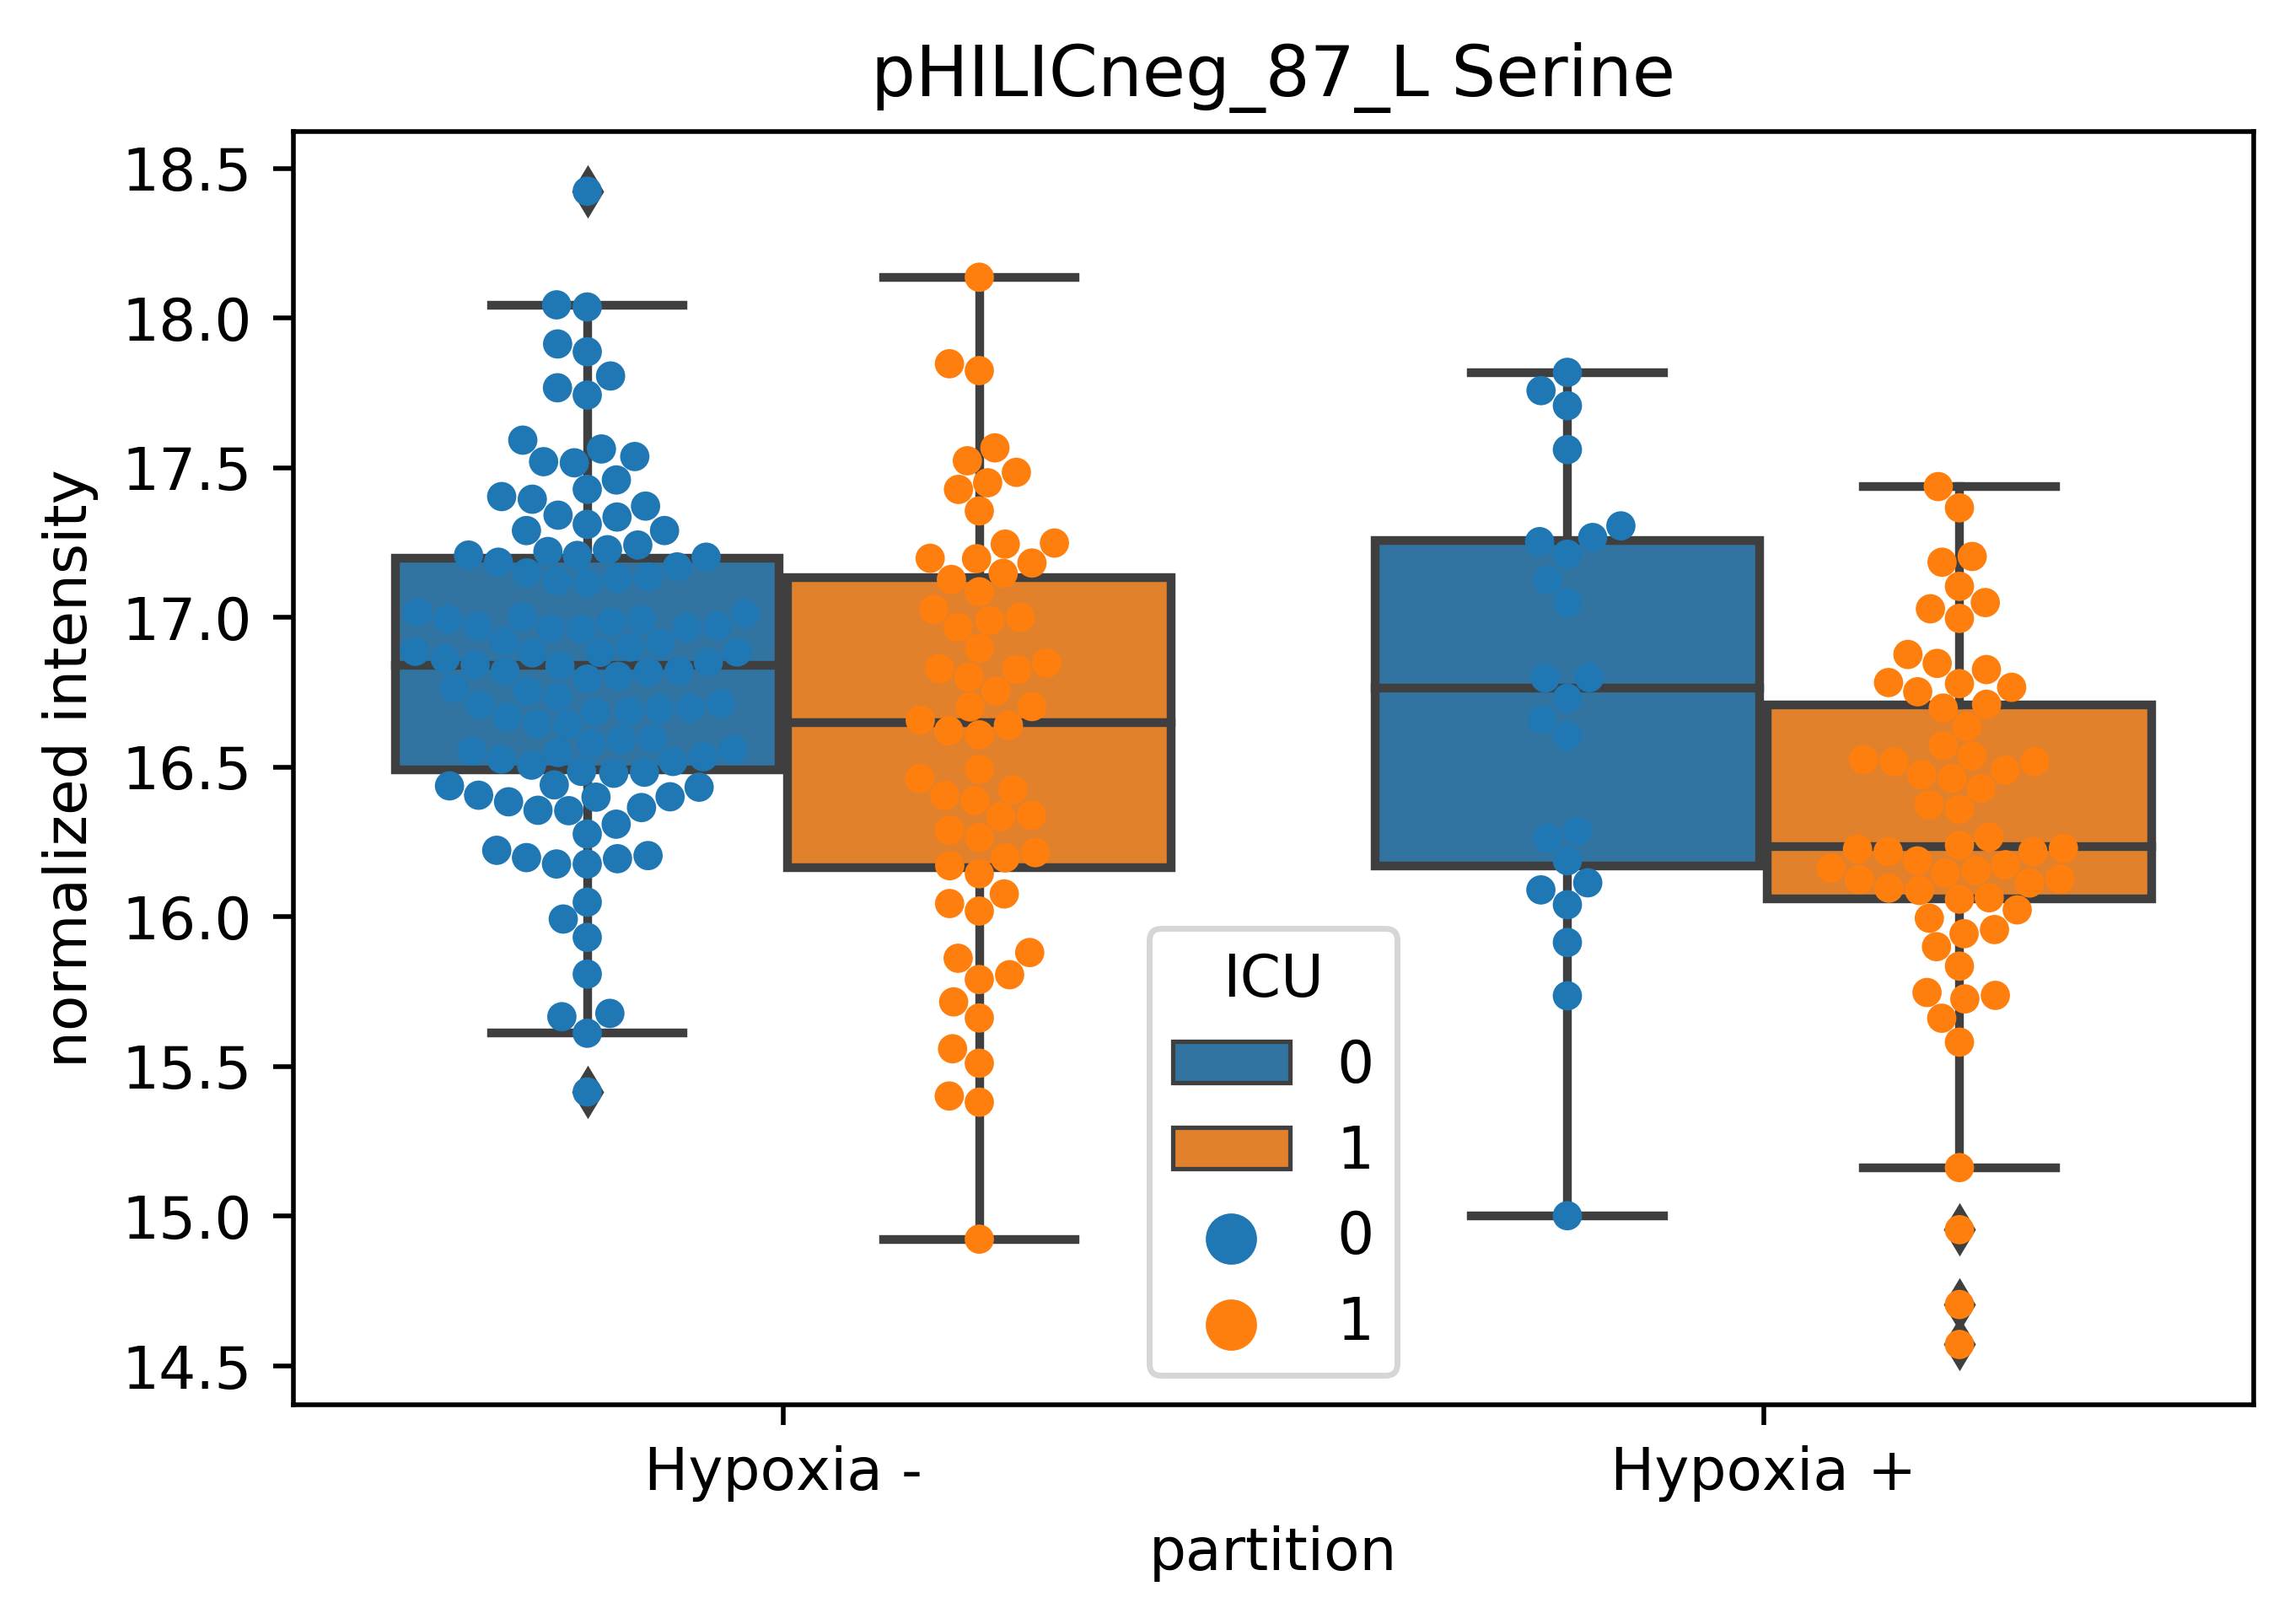

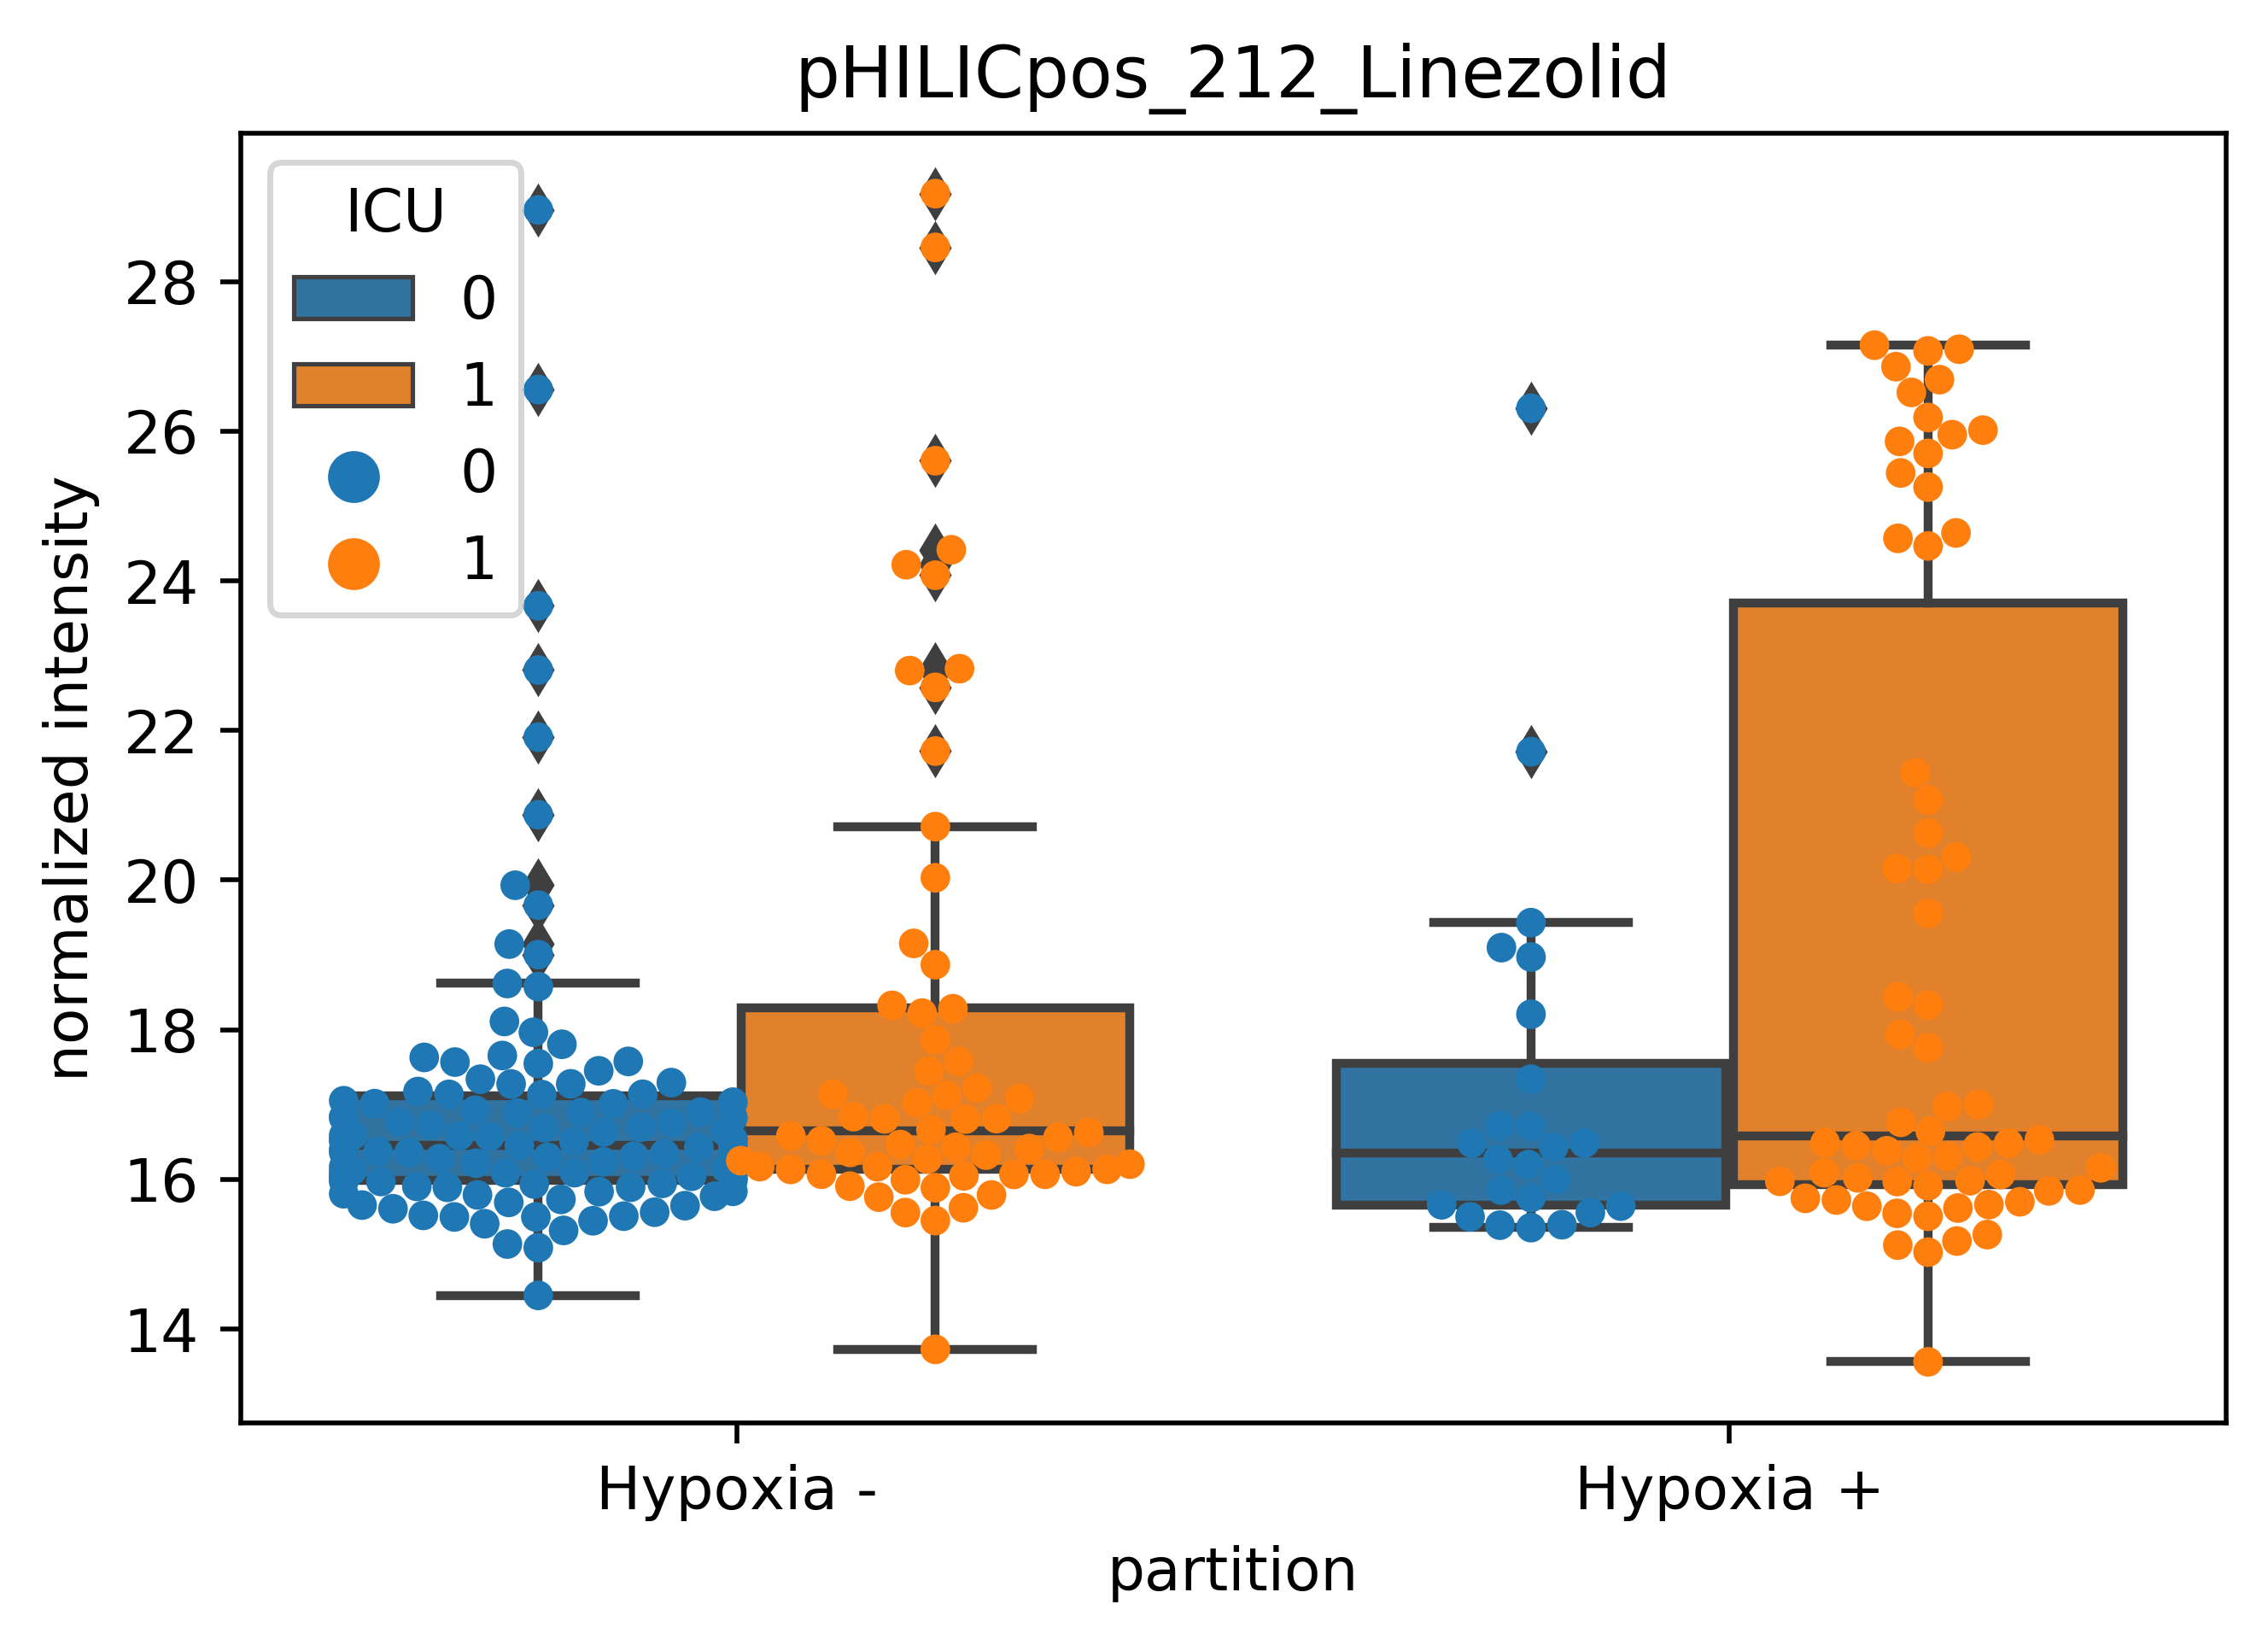

In [5]:

thresh = .5
insig_mols = []
col = "Hypoxia"

for l in range(2):
    if l == 0:
        patientsOfInterest = df[df[col] < thresh].index.values
    else:
        patientsOfInterest = df[df[col] >= thresh].index.values

    inds = [patient_ind[x] for x in patientsOfInterest]

    for met in range(len(mol_names)):

        plot_df = {}
        val = samp_int[inds,met]
        index = 0
        for x,y in zip(val,ICU_vals[inds]):
            plot_df[index] = {"ICU":y,"ratio":x}
            index += 1
        
        plot_df = pd.DataFrame.from_dict(plot_df,orient="index")

        stat,p = stats.ttest_ind(plot_df[plot_df["ICU"]==1]["ratio"].values,plot_df[plot_df["ICU"]==0]["ratio"].values,equal_var=False)

        if p > alpha:
            insig_mols.append(met)
        
insig_mols = list(set([x for x in insig_mols if len([y for y in insig_mols if y == x]) > 1]))
print(len(insig_mols))


for met in insig_mols:
    index = 0
    plot_df = {}
    for l in range(2):
        if l == 0:
            patientsOfInterest = df[df[col] < thresh].index.values
            label = col + " -"
        else:
            patientsOfInterest = df[df[col] >= thresh].index.values
            label = col + " +"

        inds = [patient_ind[x] for x in patientsOfInterest]

        val = samp_int[inds,met]
        for x,y in zip(val,ICU_vals[inds]):
            plot_df[index] = {"ICU":y,"normalized intensity":x,"partition":label}
            index += 1

    plot_df = pd.DataFrame.from_dict(plot_df,orient="index")
      
    plt.figure()    
    sb.boxplot(data=plot_df,x="partition",y="normalized intensity",hue="ICU")
    p = sb.swarmplot(data=plot_df,x="partition",y="normalized intensity",hue="ICU",dodge=True)
    plt.title(mol_names[met])
        



2


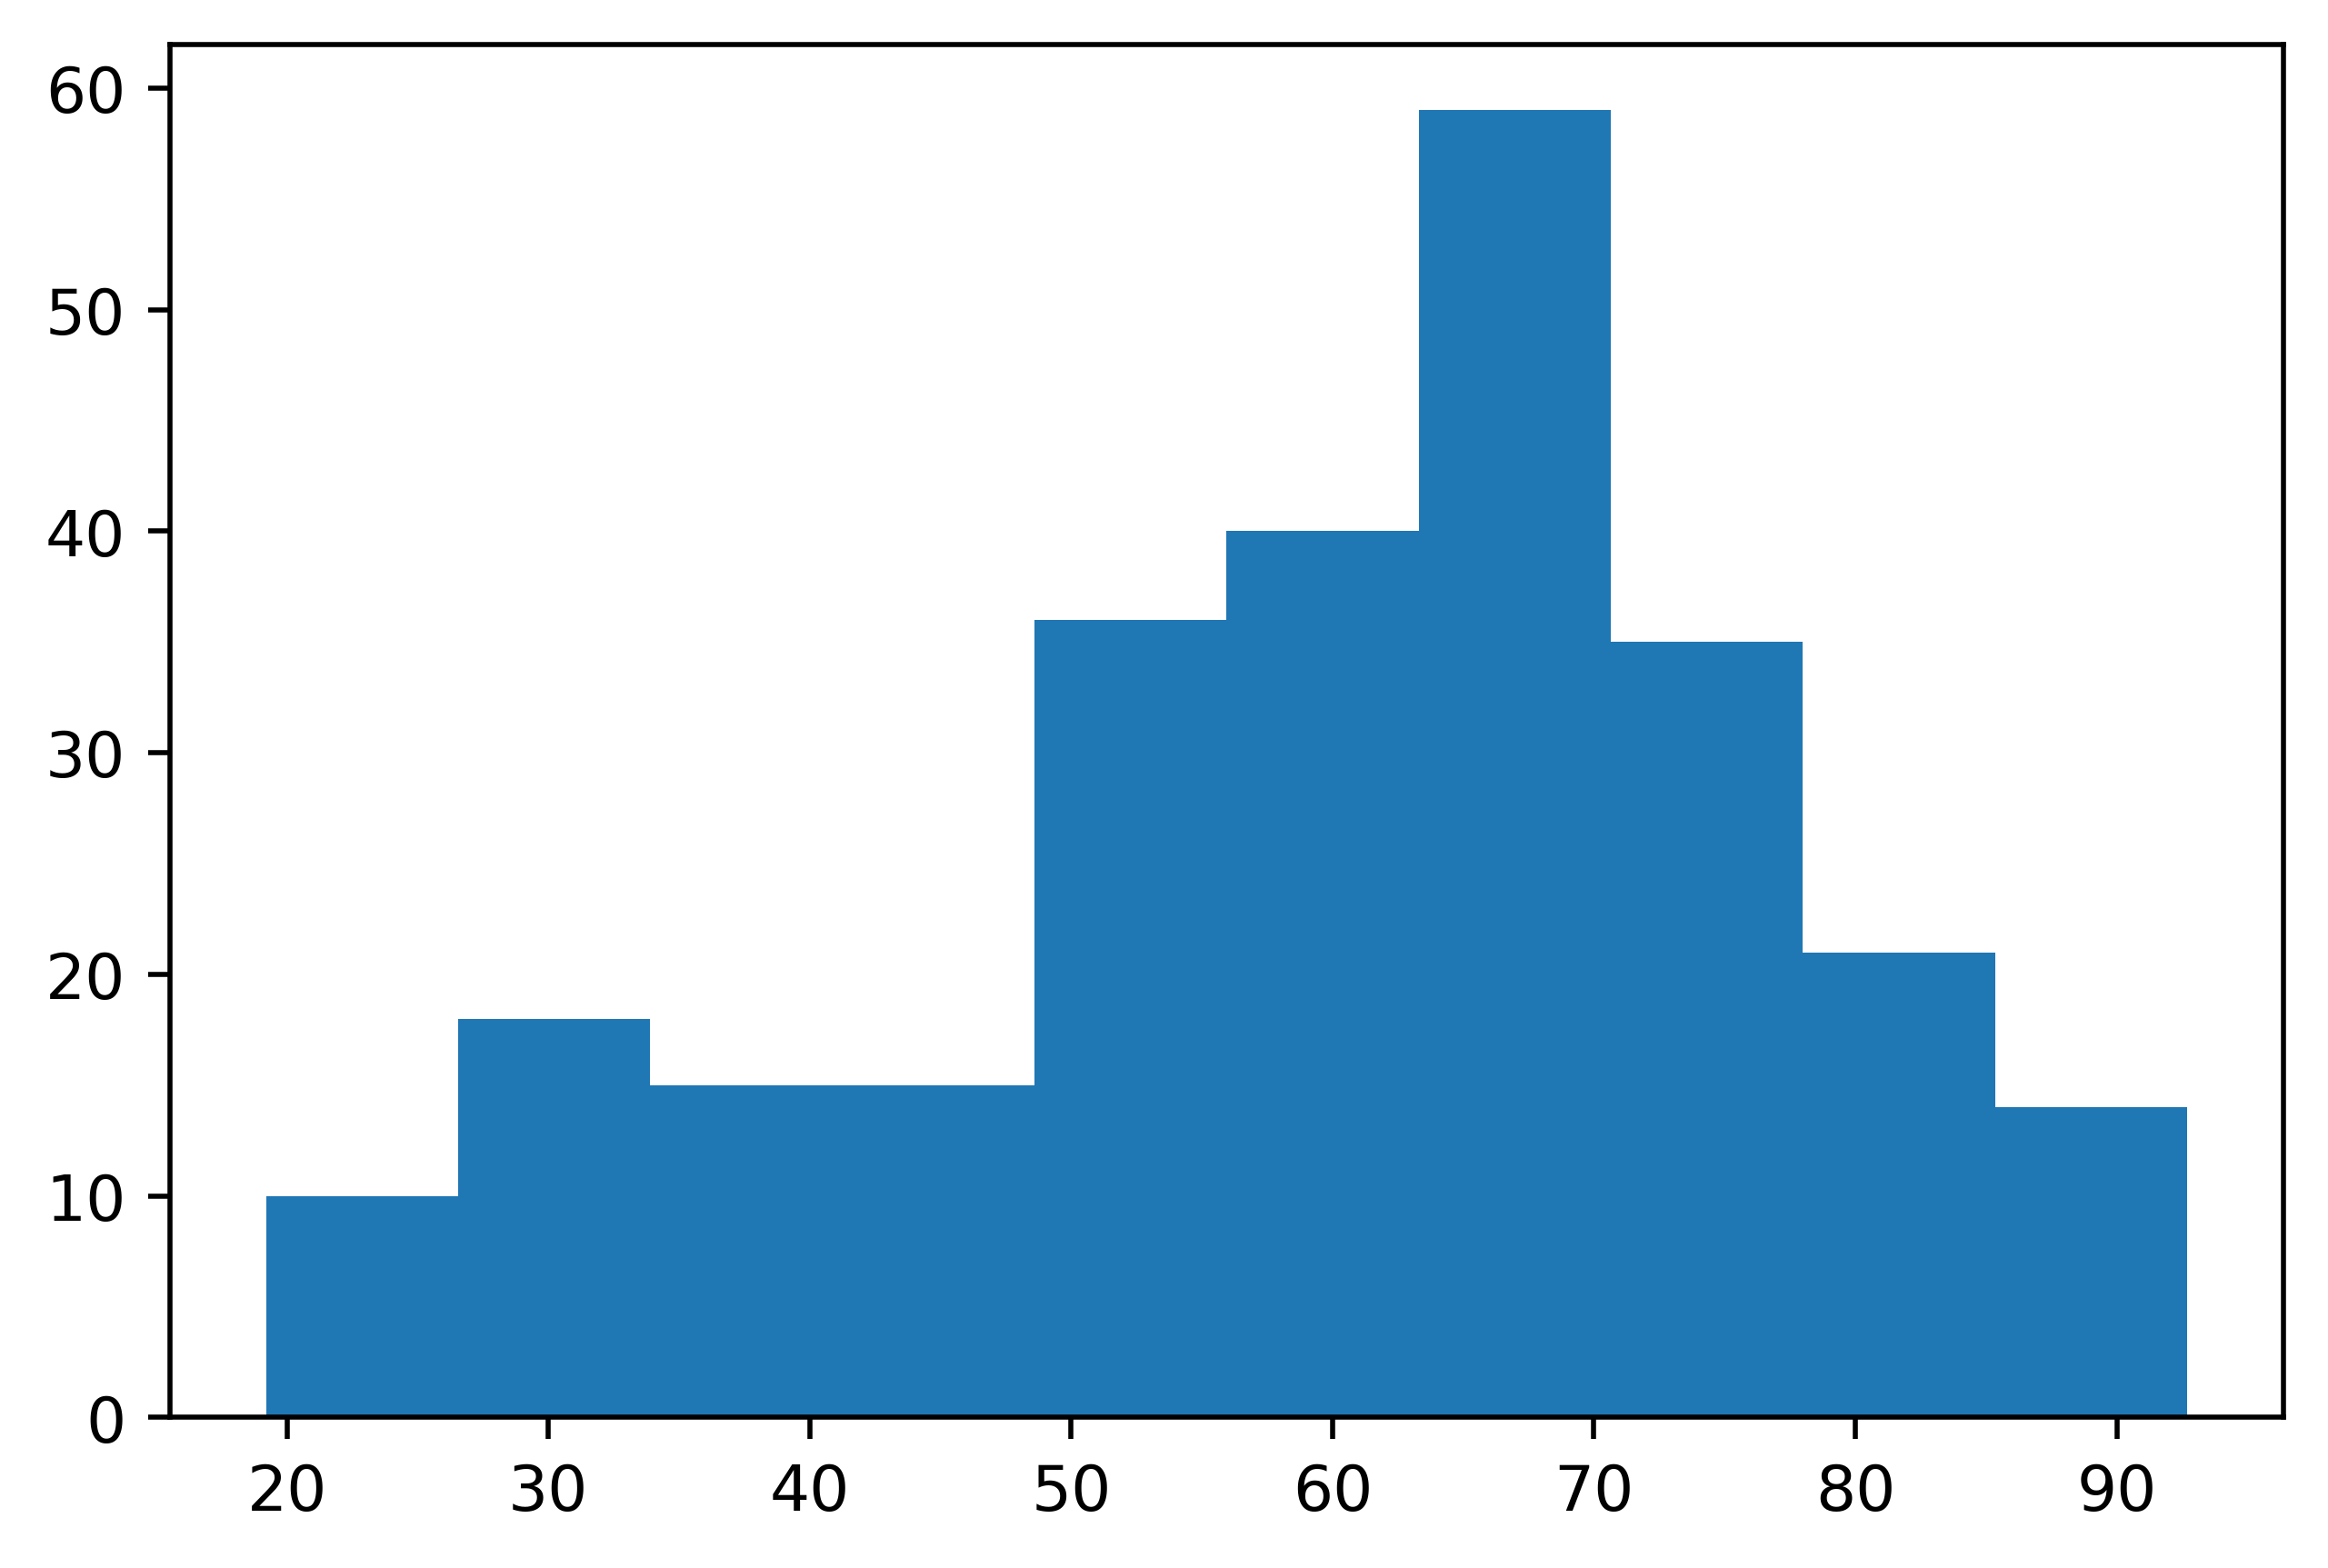

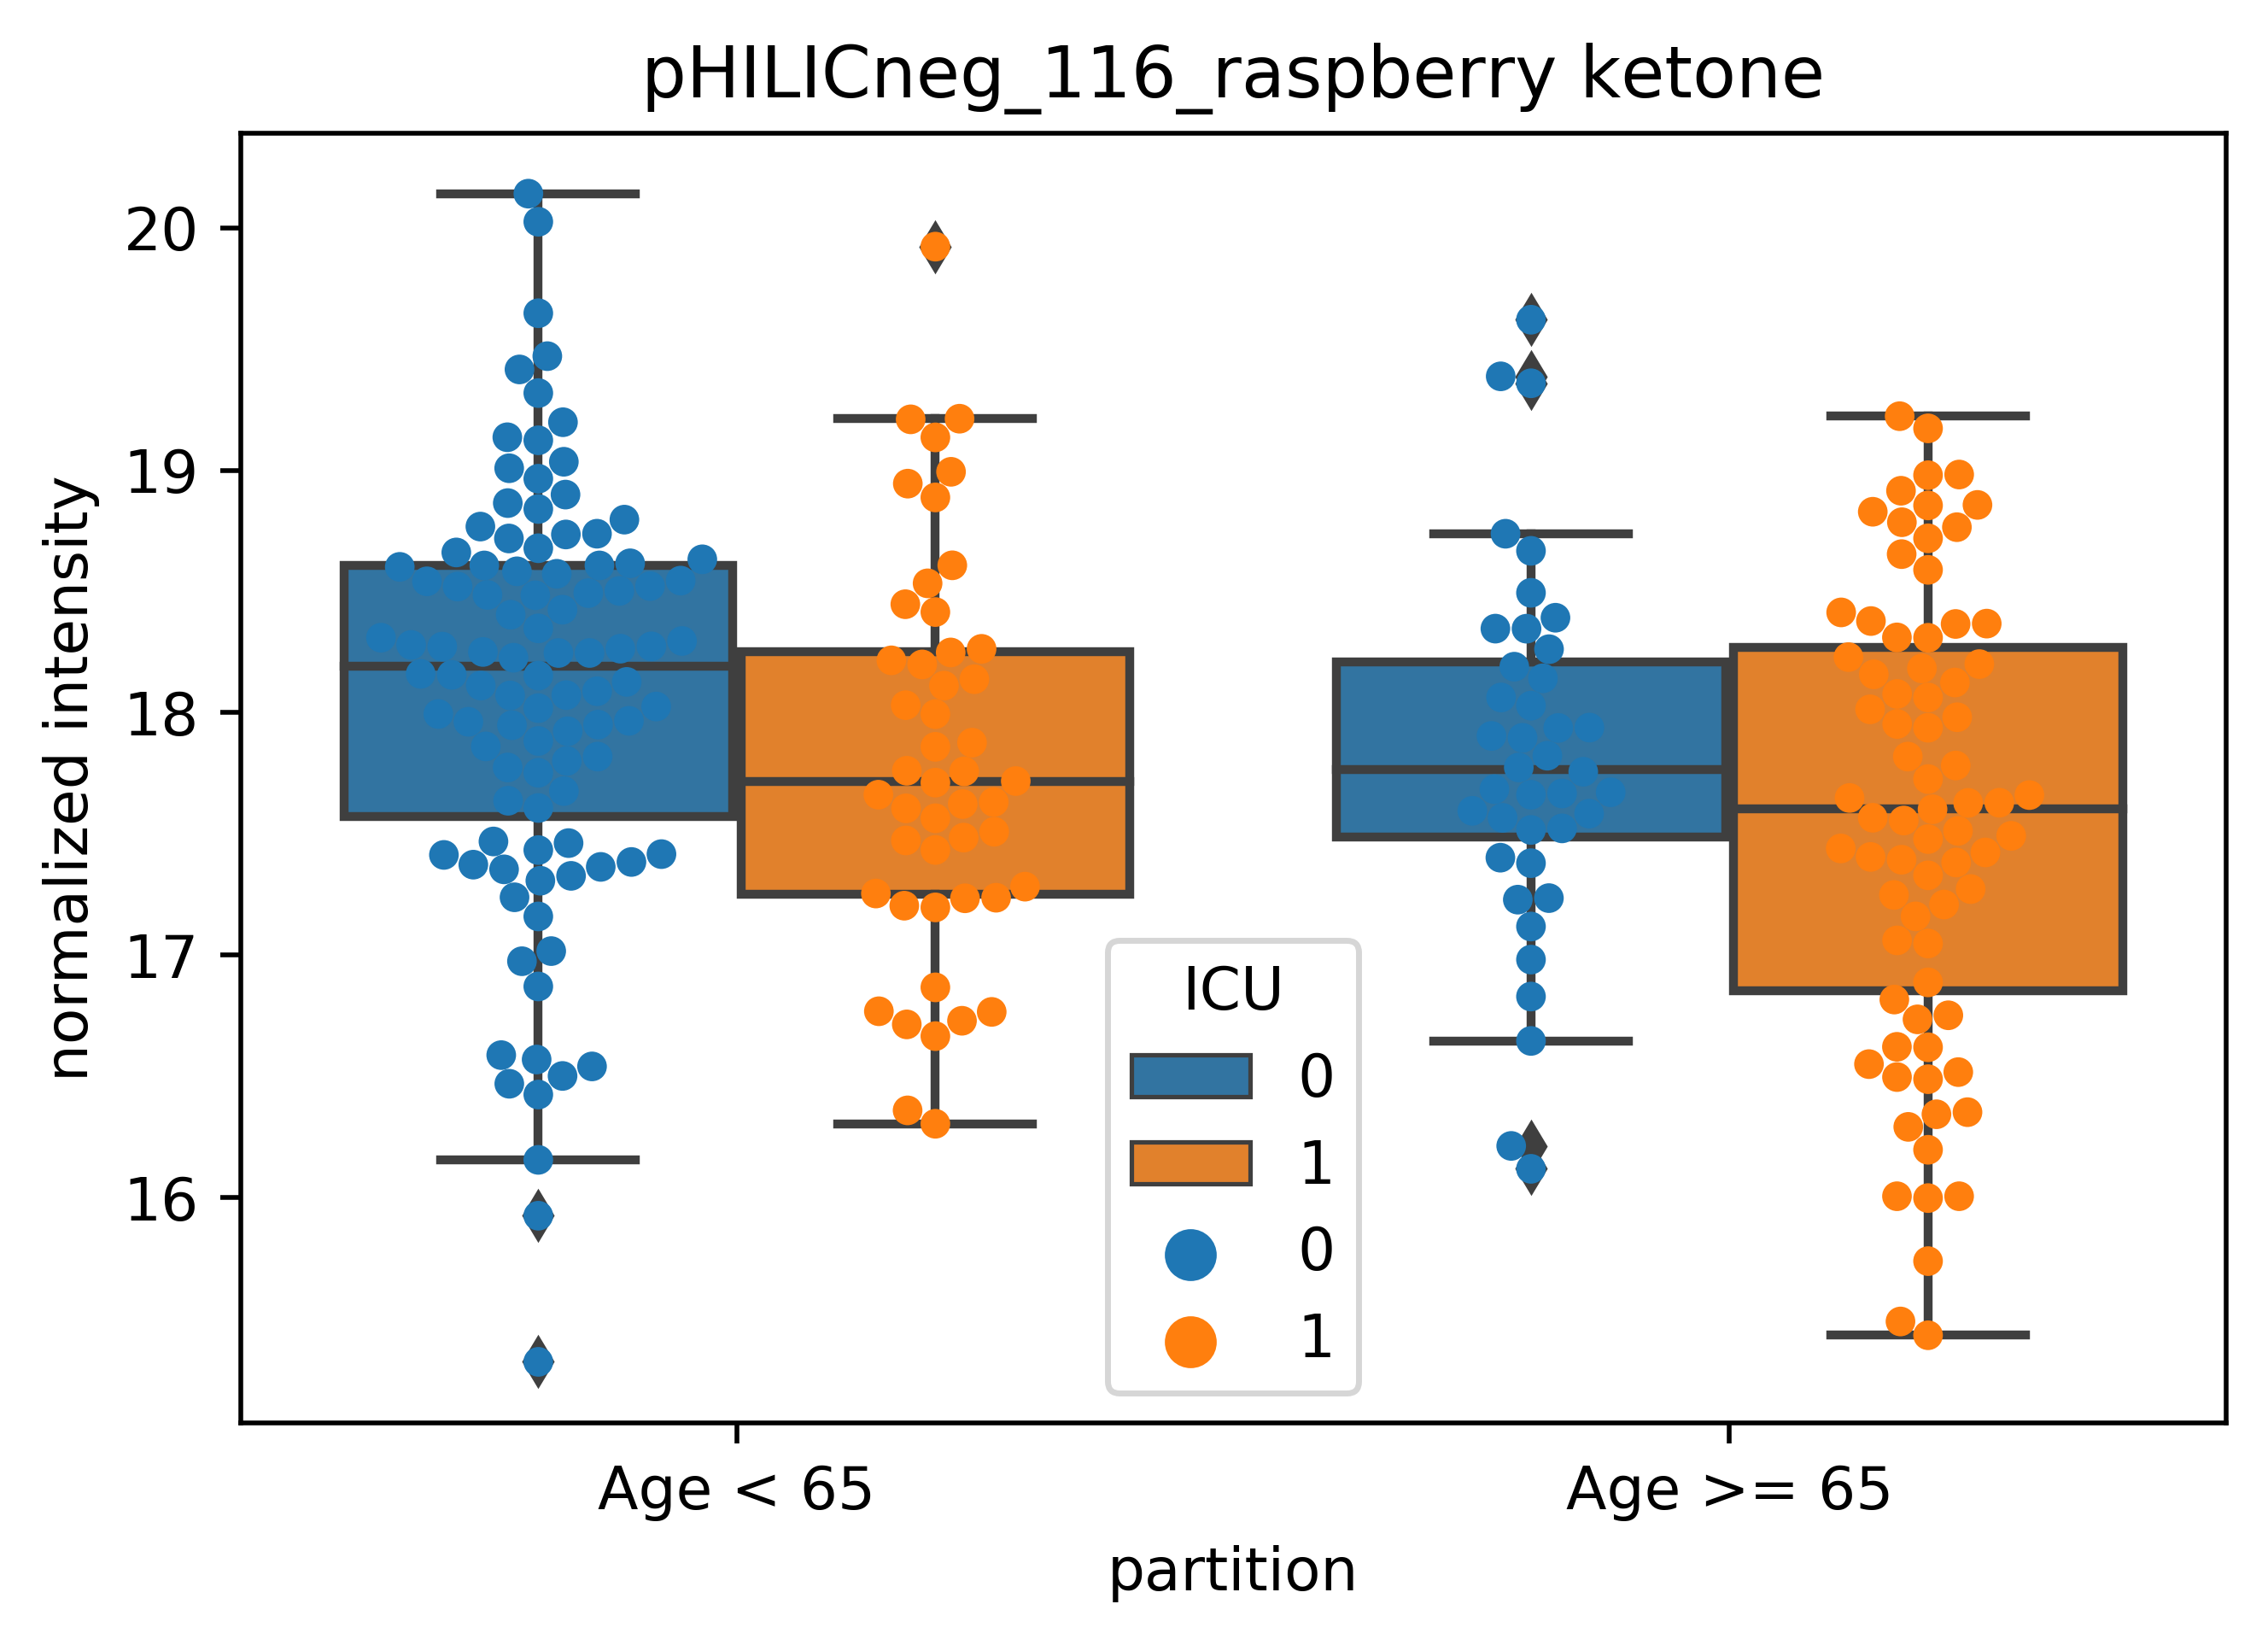

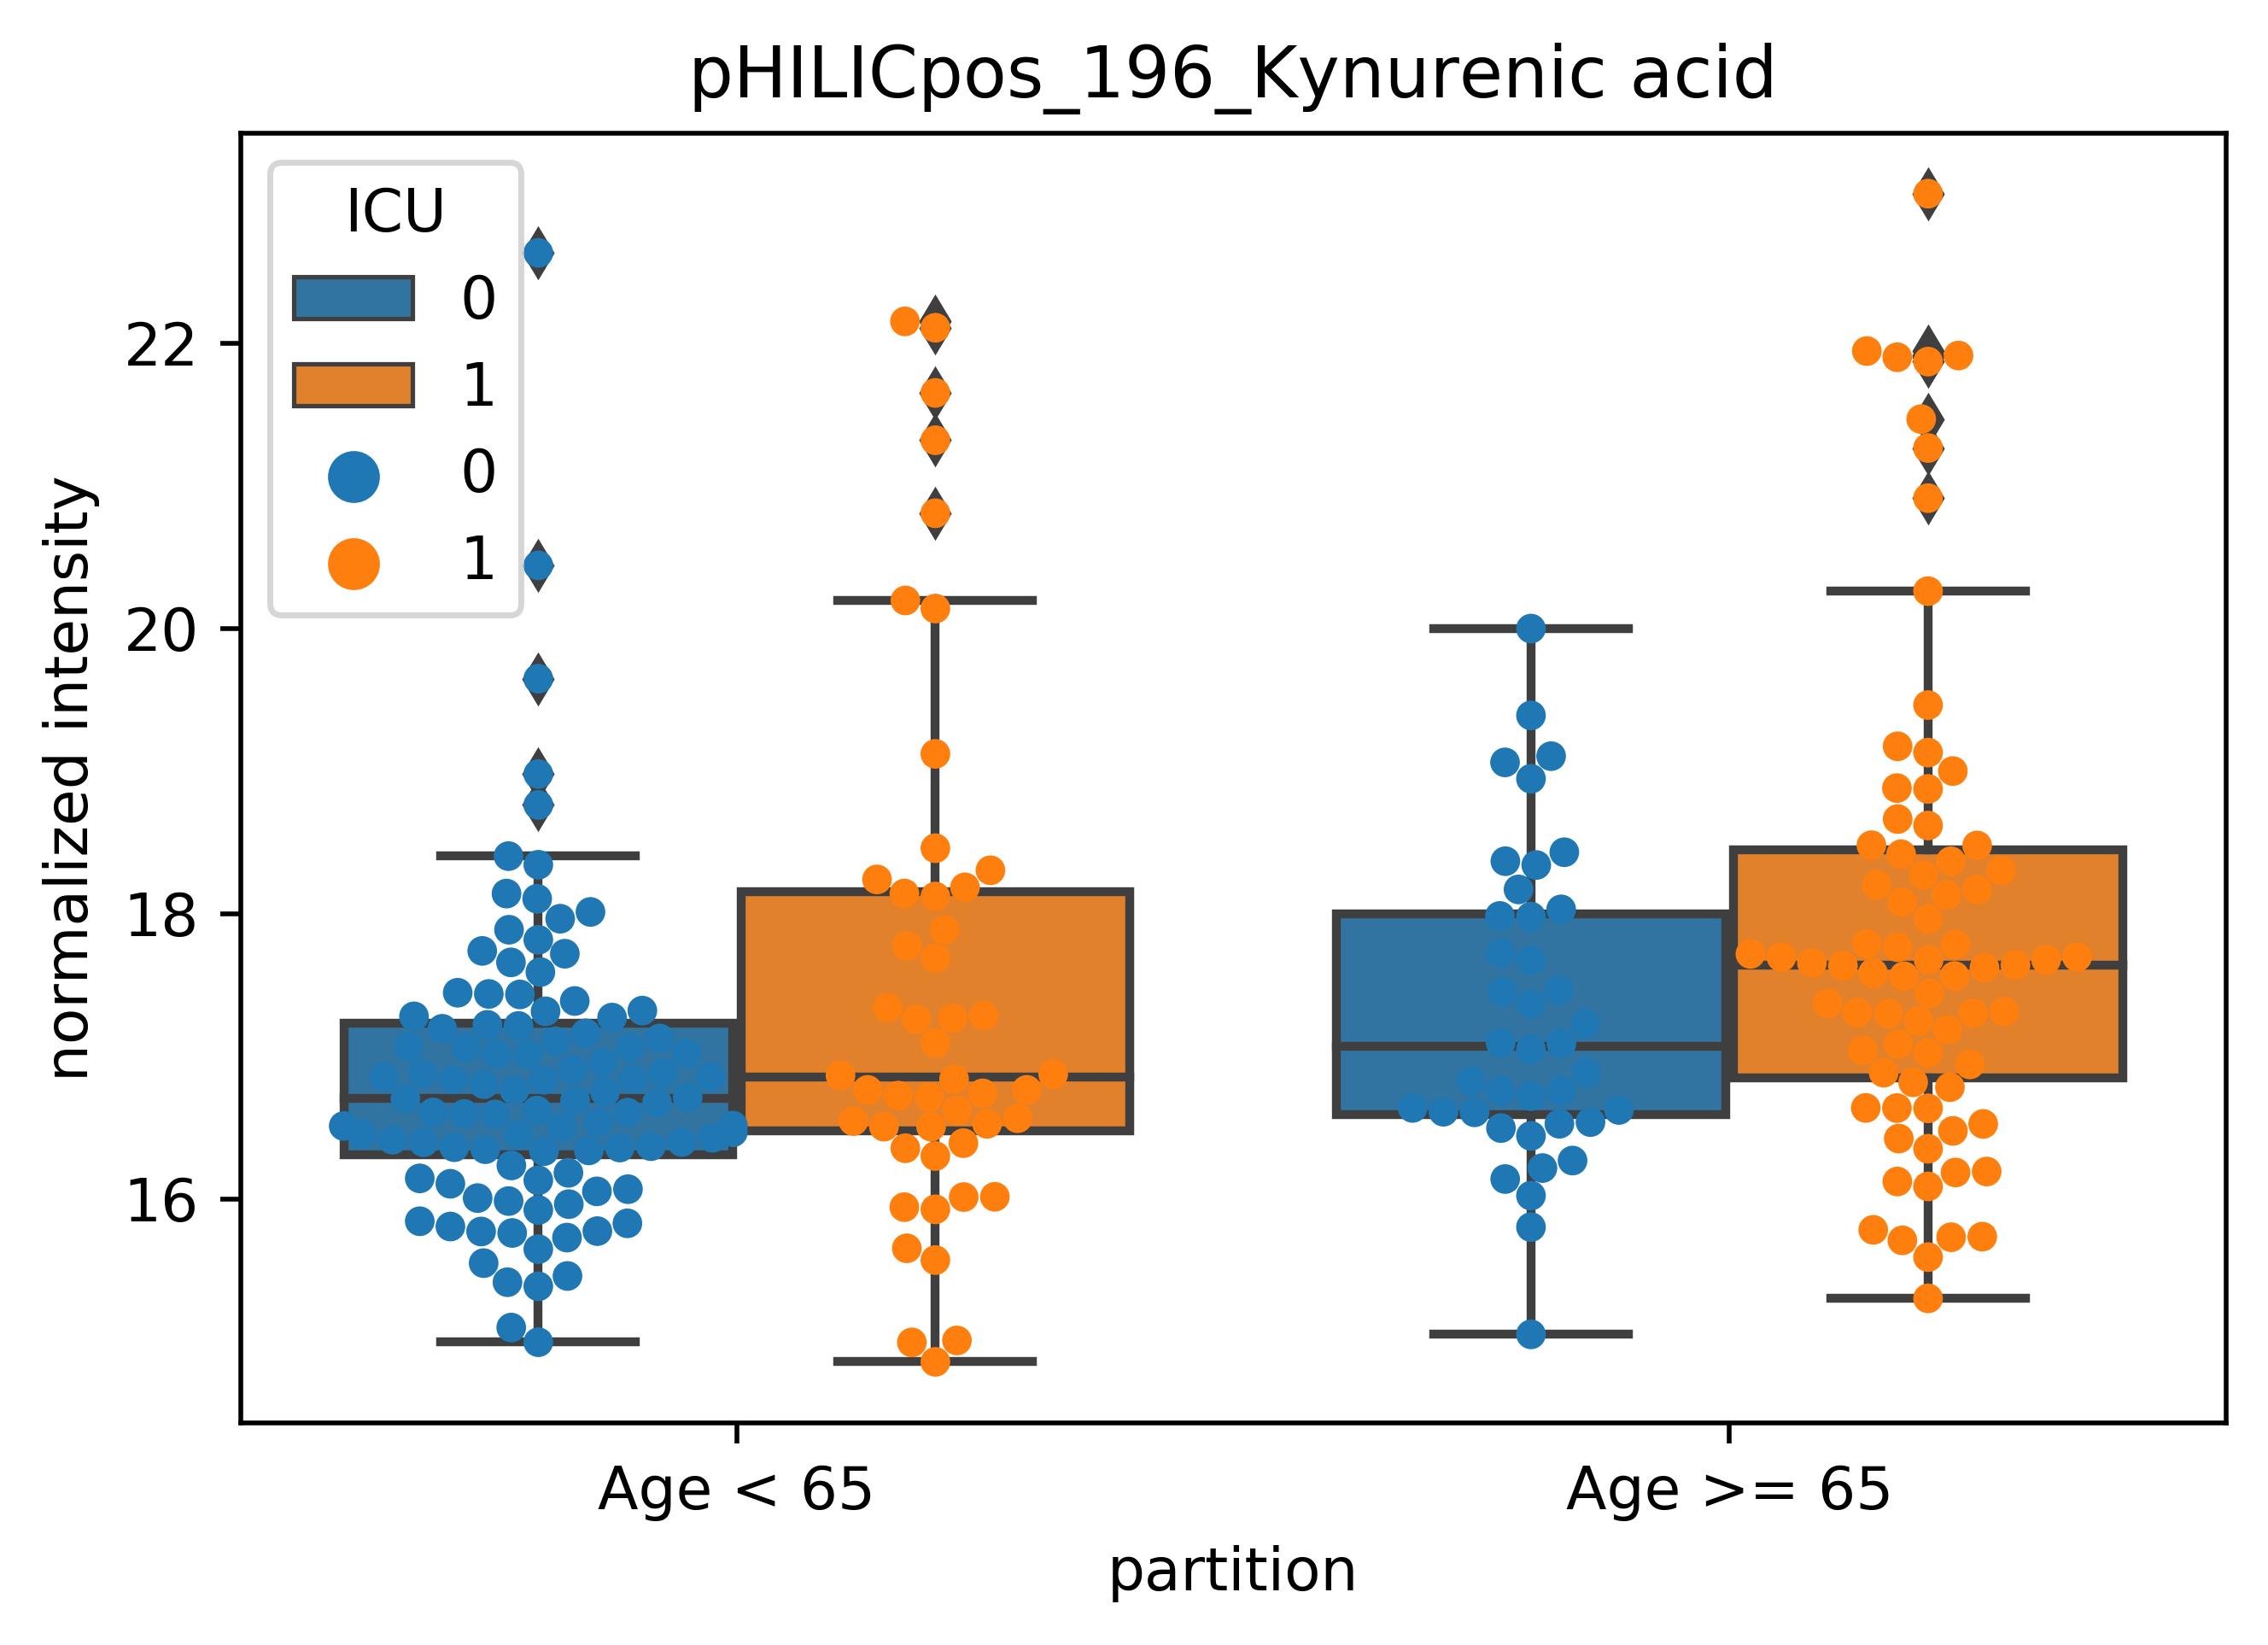

In [6]:
plt.hist(ages)

age_cutoff = 65
age_partition = [x <  age_cutoff for x in ages]
insig_mols = []

for l in range(2):
    if l == 0:
        inds = [x for x in range(len(ages)) if age_partition[x]]
    else:
        inds = [x for x in range(len(ages)) if not age_partition[x]]


    for met in range(len(mol_names)):

        plot_df = {}
        val = samp_int[inds,met]
        index = 0
        for x,y in zip(val,ICU_vals[inds]):
            plot_df[index] = {"ICU":y,"ratio":x}
            index += 1
        
        plot_df = pd.DataFrame.from_dict(plot_df,orient="index")

        stat,p = stats.ttest_ind(plot_df[plot_df["ICU"]==1]["ratio"].values,plot_df[plot_df["ICU"]==0]["ratio"].values,equal_var=False)

        if p > alpha:
            insig_mols.append(met)
        
insig_mols = list(set([x for x in insig_mols if len([y for y in insig_mols if y == x]) > 1]))
print(len(insig_mols))


for met in insig_mols:
    index = 0
    plot_df = {}
    for l in range(2):
        if l == 0:
            inds = [x for x in range(len(ages)) if age_partition[x]]
            label = "Age < " + str(age_cutoff)
        else:
            inds = [x for x in range(len(ages)) if not age_partition[x]]
            label = "Age >= " + str(age_cutoff)


        val = samp_int[inds,met]
        for x,y in zip(val,ICU_vals[inds]):
            plot_df[index] = {"ICU":y,"normalized intensity":x,"partition":label}
            index += 1

    plot_df = pd.DataFrame.from_dict(plot_df,orient="index")
      
    plt.figure()    
    sb.boxplot(data=plot_df,x="partition",y="normalized intensity",hue="ICU")
    p = sb.swarmplot(data=plot_df,x="partition",y="normalized intensity",hue="ICU",dodge=True)
    plt.title(mol_names[met])
        



0


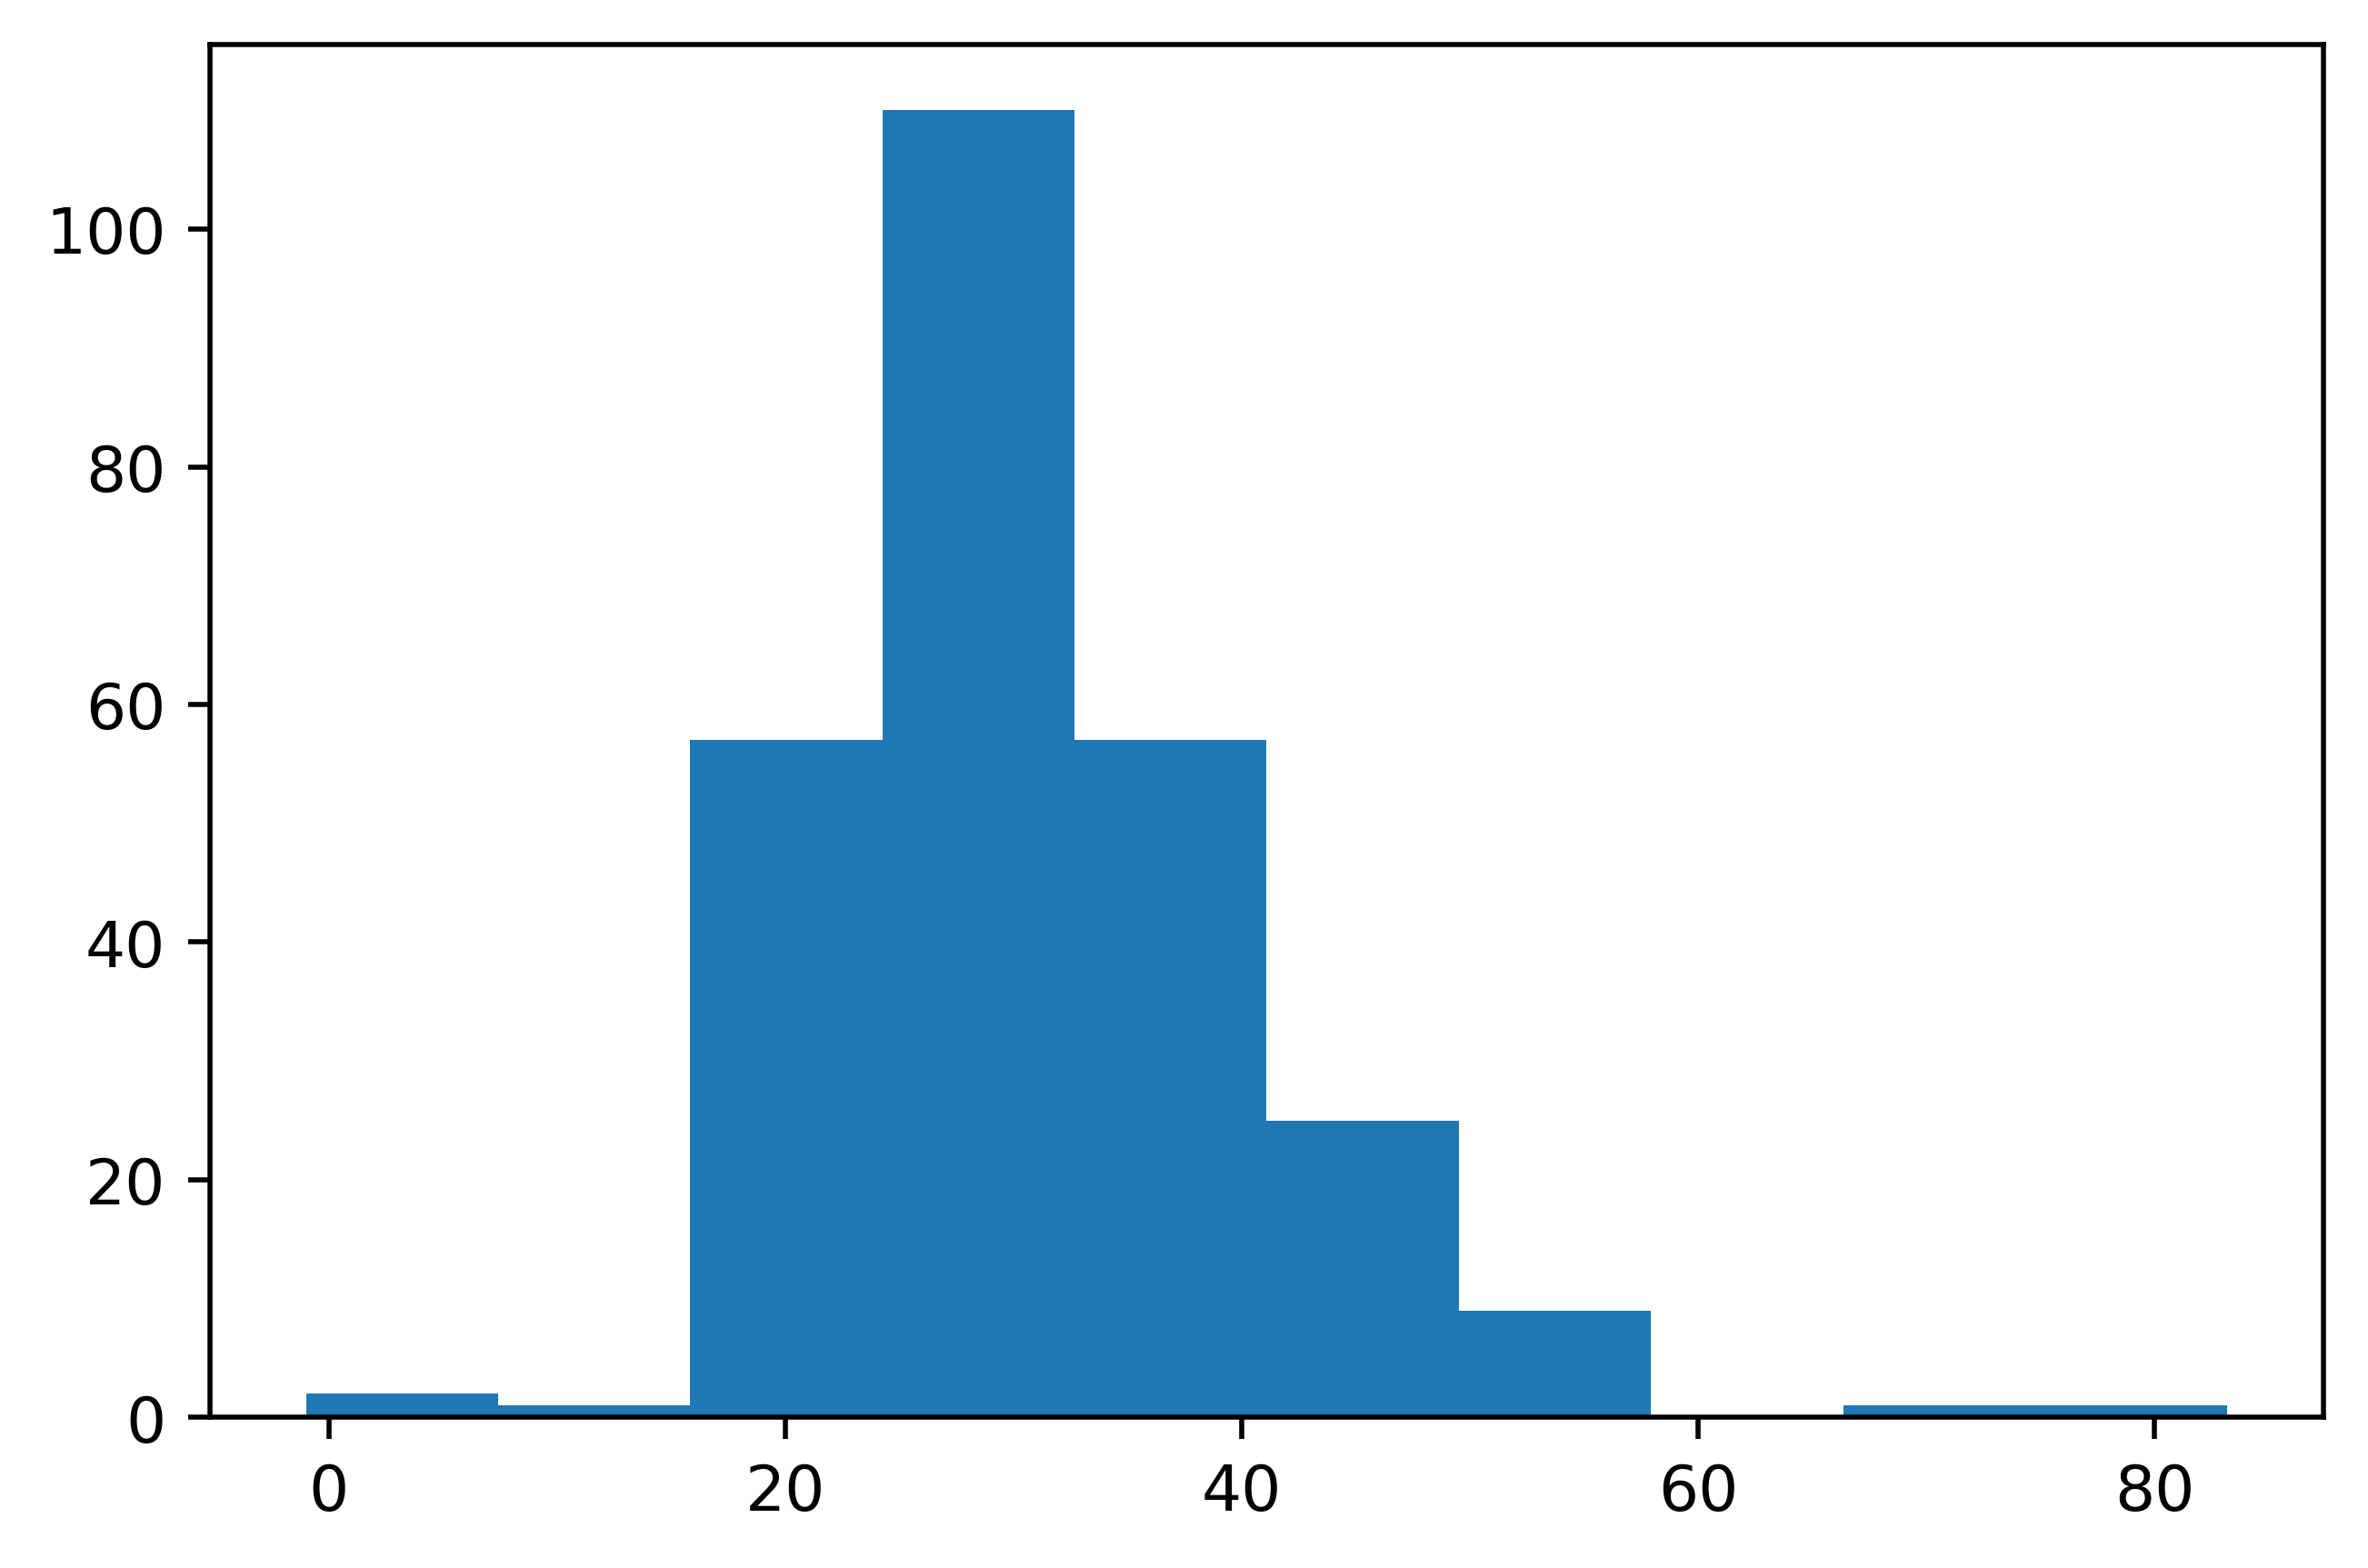

In [7]:
plt.hist(bmis)

bmi_cutoff = 25
bmi_partition = [x <  bmi_cutoff for x in bmis]
insig_mols = []

for l in range(2):
    if l == 0:
        inds = [x for x in range(len(bmis)) if bmi_partition[x] and bmis[x] > 0]
    else:
        inds = [x for x in range(len(bmis)) if not bmi_partition[x] and bmis[x] > 0]


    for met in range(len(mol_names)):

        plot_df = {}
        val = samp_int[inds,met]
        index = 0
        for x,y in zip(val,ICU_vals[inds]):
            plot_df[index] = {"ICU":y,"ratio":x}
            index += 1
        
        plot_df = pd.DataFrame.from_dict(plot_df,orient="index")

        stat,p = stats.ttest_ind(plot_df[plot_df["ICU"]==1]["ratio"].values,plot_df[plot_df["ICU"]==0]["ratio"].values,equal_var=False)

        if p > alpha:
            insig_mols.append(met)
        
insig_mols = list(set([x for x in insig_mols if len([y for y in insig_mols if y == x]) > 1]))
print(len(insig_mols))


for met in insig_mols:
    index = 0
    plot_df = {}
    for l in range(2):
        if l == 0:
            inds = [x for x in range(len(bmis)) if bmi_partition[x] and bmis[x] > 0]
            label = "BMI < " + str(bmi_cutoff)
        else:
            inds = [x for x in range(len(bmis)) if not bmi_partition[x] and bmis[x] > 0]
            label = "BMI >= " + str(bmi_cutoff)


        val = samp_int[inds,met]
        for x,y in zip(val,ICU_vals[inds]):
            plot_df[index] = {"ICU":y,"normalized intensity":x,"partition":label}
            index += 1

    plot_df = pd.DataFrame.from_dict(plot_df,orient="index")
      
    plt.figure()    
    sb.boxplot(data=plot_df,x="partition",y="normalized intensity",hue="ICU")
    p = sb.swarmplot(data=plot_df,x="partition",y="normalized intensity",hue="ICU",dodge=True)
    plt.title(mol_names[met])
        

